[Team Members]
- Allen Isaac Jose
- Ekansh Sharma
- Hamsadatta Perur

##### [REFERENCE] - small code snippets are obtained via ChatGPT and modified

# Import packages

In [1]:
!pip install dtw

In [2]:
import math
import sys
import os
import pickle
import time
import itertools
import random
from typing import Dict
import networkx as nx
from dtw import dtw
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import art3d
from scipy import linalg
from scipy.stats import multivariate_normal
from scipy.interpolate import splprep, splev
from scipy.spatial.transform import Rotation
from sklearn.mixture import GaussianMixture

In [3]:
%matplotlib notebook

# Learning the trajectory

## Generate data

<IPython.core.display.Javascript object>


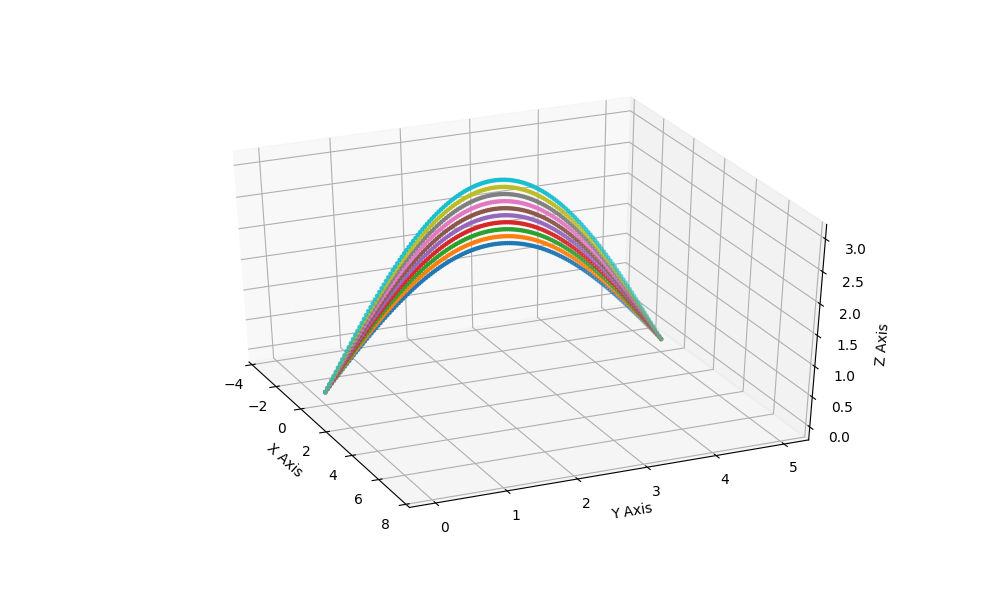

In [4]:
# 3D visualization of dataset
fig = plt.figure(figsize=(10,6))
ax1 = fig.gca(projection='3d')
ax1.set_xlabel('X Axis')
ax1.set_ylabel('Y Axis')
ax1.set_zlabel('Z Axis')
ax1.set_xlim([-4, 8])

# x,y,z,time
data = np.zeros((1,4))

# Number of points in between (including start and end points)
num_points = 150

# For the data to be generated,
# x cordinate is at 0 for start and end
# y cordinate ranges from 0 to 5
# z cordinate is the amplitude that changes from 2 to 3

# same X values
X = np.array([0]*150, dtype=float)
# Y over a range of 0 to 5
Y = np.linspace(0, 5, num_points)
# Wavelength parameters for Z
amplitudes = np.linspace(2,3,10)
frequency = 0.1
phase = 0.0

# for different amplitudes
for a in amplitudes:
    # values for Z. half wavelength of sine wave
    Z = a * np.sin(2 * np.pi * frequency * Y + phase)
    temp = np.stack((X, Y, Z), axis=1)
    # add time component
    temp = np.hstack((temp, np.array([i for i in range(len(temp))]).reshape(-1,1)))
    # append the current dataset to the data array
    data = np.vstack((data, temp))
    ax1.scatter(X, Y, Z, marker='.')

# remove first row which is reference
data = data[1:,:]
# multiple copy of the same data to double the dataset length
data = np.vstack((data, data))
plt.show()

## Function to plot GMM model

In [5]:
# reference - https://stackoverflow.com/questions/7819498/plotting-ellipsoid-with-matplotlib
def plot_GMM(X: np.ndarray,
             Y: np.ndarray,
             means: np.ndarray,
             covariances: Dict,
             ax: matplotlib.figure.Axes):             
    """ Function to plot ellipsoids for a Gaussian Mixture Model.
    
    Parameters
    ----------
    X : np.ndarray
        The input data.
    Y : ndarray
        The cluster labels.
    means : np.ndarray
        The means of the Gaussian Mixture Model.
    covariances : np.ndarray
        The covariances of the Gaussian Mixture Model.
    ax : matplotlib.figure.Axes
        The matplotlib Axes to plot on.
    """
    
    for g in range(len(means)):
        
        datapoints = np.copy(X[np.where(Y == g)])
        
        # Compute the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eig(covariances[g])
        
        # Get the indices of the largest and smallest eigenvalues
        max_idx = np.argmax(eigenvalues)
        min_idx = np.argmin(eigenvalues)
        # to avoid negative values for eigenvalues to perform sqrt
        eigenvalues = np.abs(eigenvalues)
        # Compute the lengths of the principal axes of the ellipsoid
        a, b, c = 3 * np.sqrt(eigenvalues)
        
        # Compute the rotation matrix to align the ellipsoid with the principal axes
        rotation_matrix = eigenvectors.T
        
        # Generate a sphere and transform it to an ellipsoid using the principal axes and rotation matrix
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = a * np.outer(np.cos(u), np.sin(v))
        y = b * np.outer(np.sin(u), np.sin(v))
        z = c * np.outer(np.ones_like(u), np.cos(v))

        for i in range(len(x)):
            for j in range(len(x)):
                [x[i, j], y[i, j], z[i, j]] = np.dot([x[i, j], y[i, j], z[i, j]], rotation_matrix) + means[g]
        
        # plotting the datapoints based on the cluster label
        ax.scatter(datapoints[:,0], datapoints[:,1], datapoints[:,2], alpha=0.1, zorder=2)
        
        # plotting the ellipsoid. If not needed, comment this line
        ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, alpha=0.1)
    
    return None

## Fitting GMM on generated data

In [6]:
# number of gaussians
k = 8

# Initializing GMM
gmm = GaussianMixture(n_components=k)

# Fitting GMM to the datset
gmm.fit(data)

# Predict the cluster labels for each data point
labels = gmm.predict(data)

print("Labels of the datapoints \n", labels, "\n")
print("Mean of each gaussian cluster \n", gmm.means_, "\n")
print("Covariance matrix of each gaussian cluster \n", gmm.covariances_)

Labels of the datapoints 
 [1 1 1 ... 2 2 2] 

Mean of each gaussian cluster 
 [[  0.           2.7794318    2.39420087  82.82706759]
 [  0.           0.18766872   0.29415857   5.59252782]
 [  0.           4.80137017   0.31113333 143.08083107]
 [  0.           1.46559014   1.96014061  43.67458617]
 [  0.           3.4543521    2.02813008 102.93969252]
 [  0.           0.75323688   1.14201518  22.44645891]
 [  0.           2.13772316   2.37715901  63.7041503 ]
 [  0.           4.20120334   1.20465915 125.19585963]] 

Covariance matrix of each gaussian cluster 
 [[[ 1.00000000e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  7.52294227e-02 -2.82574547e-02  2.24180700e+00]
  [ 0.00000000e+00 -2.82574547e-02  1.03789735e-01 -8.42072151e-01]
  [ 0.00000000e+00  2.24180700e+00 -8.42072151e-01  6.68058495e+01]]

 [[ 1.00000000e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.69619072e-02  2.65876513e-02  5.05435035e-01]
  [ 0.00000000e+00  2.6

## Visualising the GMM model

<IPython.core.display.Javascript object>


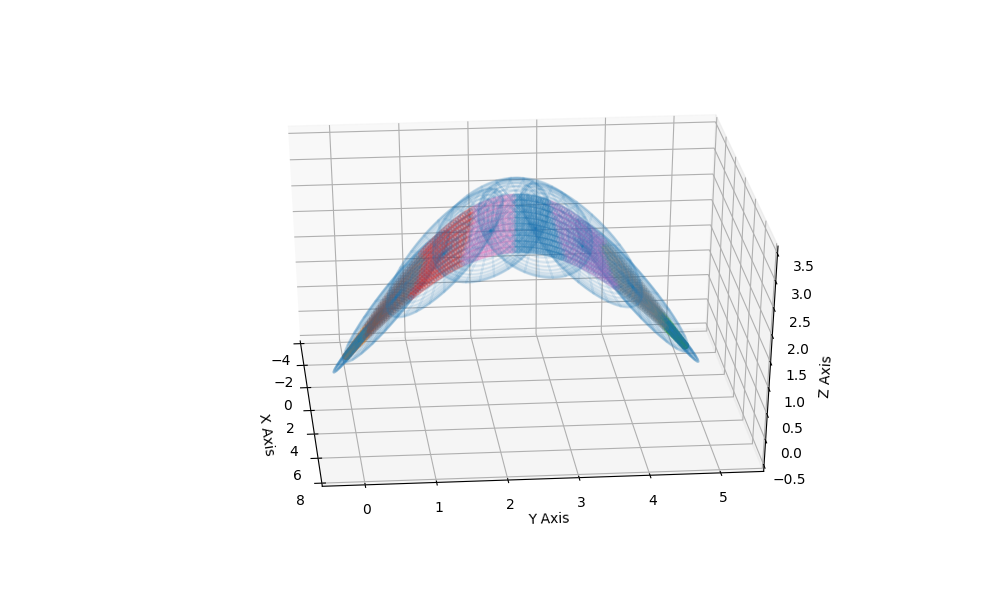

In [7]:
## Visualizing the output with ellipsoids
fig = plt.figure(figsize=(10,6))
ax2 = fig.add_subplot(111, projection='3d')
ax2.set_xlabel('X Axis')
ax2.set_ylabel('Y Axis')
ax2.set_zlabel('Z Axis')
ax2.set_xlim([-4, 8])

# ignore last index of mean and variance as it is related to time
plot_GMM(data, labels, gmm.means_[:,:3], gmm.covariances_[:,:3,:3], ax2)

plt.show()

## Code for Gaussian Mixture Regression(GMR) [1]

Reference: 
[1] https://github.com/BatyaGG/Gaussian-Mixture-Models

In [8]:
# compute the probability density function
def gaussPDF(Data, Mu, Sigma):
    realmin = sys.float_info[3]
    # nbVar - number of dimensions (4 if x,y,z,t)
    # nbData - number of datapoints
    nbVar, nbData = np.shape(Data)
    Data = np.transpose(Data) - np.tile(np.transpose(Mu), (nbData, 1))
    prob = np.sum(np.dot(Data, np.linalg.inv(Sigma))*Data, 1)
    prob = np.exp(-0.5*prob)/np.sqrt((np.power((2*math.pi), nbVar))*np.absolute(np.linalg.det(Sigma))+realmin)
    return prob

In [9]:
# Gaussian Mixture Regression
# (weight, mean, covariance, data, the time index for which pose has to be sampled,
#  index of time, index of the poses to be generated)
def GMR(Priors, Mu, Sigma, x, input, output):
    lo = np.size(output)
    nbData = np.size(x)
    nbVar = np.size(Mu, 0)
    nbStates = np.size(Sigma, 2)
    realmin = sys.float_info[3]
    Pxi = np.ndarray(shape=(nbData, nbStates))
    x = np.reshape(x,(1,nbData))
    y_tmp = np.ndarray(shape = (nbVar-1, nbData, nbStates))
    Sigma_y_tmp = np.ndarray(shape = (lo, lo, 1, nbStates))

    for i in range (0,nbStates):
        m = Mu[input,i]
        m = np.reshape(m,(np.size(input),1))
        s = Sigma[input, input, i]
        s = np.reshape(s, (np.size(input),np.size(input)))
        Pxi[:,i] = np.multiply(Priors[i],gaussPDF(x,m,s))
    beta = np.divide(Pxi,np.tile(np.reshape(np.sum(Pxi,1),(nbData, 1))+realmin,(1,nbStates)))
    for j in range (0,nbStates):
        a = np.delete(Mu, np.s_[input], axis = 0)
        a = a[:,j]
        a = np.reshape(a,(nbVar-np.size(input),1))
        a = np.tile(a, (1, nbData))
        b = np.delete(Sigma[:,:,j], 0, axis = 0)
        b = np.delete(b, np.s_[1:nbVar], axis = 1)
        c = Sigma[input, input, j]
        c = np.reshape(c, (1,1))
        c = np.linalg.inv(c)
        c = np.dot(b, c)
        d = np.reshape(Mu[input, j], (1,1))
        d = np.tile(d, (1,nbData))
        d = x - d
        d = np.dot(c, d)
        y_tmp[:,:,j] = a + d
    # pravilno
    a, b = np.shape(beta)
    beta_tmp = np.reshape(beta, (1,a,b))
    a = np.tile(beta_tmp,(lo,1,1))
    y_tmp2 = a*y_tmp
    # print('1')
    # print(y_tmp2[:,:,0])
    # print('2')
    # print(y_tmp2[:, :, 1])
    # print('3')
    # print(y_tmp2[:, :, 2])
    # print('4')
    # print(y_tmp2[:, :, 3])
    y = np.sum(y_tmp2,2)

    for j in range(0, nbStates):
        a = np.delete(Sigma[:,:,j], 0, axis = 0)
        a = np.delete(a, 0, axis = 1)
        b = np.delete(Sigma[:, :, j], 0, axis=0)
        b = np.delete(b, np.s_[1:nbVar], axis=1)
        c = Sigma[input, input, j]
        c = np.reshape(c, (1, 1))
        c = np.linalg.inv(c)
        c = np.dot(b, c)
        d = np.delete(Sigma[:,:,j], 0,axis = 1)
        d = np.delete(d, np.s_[1:nbVar], axis = 0)
        d = np.dot(c, d)
        Sigma_y_tmp[:,:,0,j] = a - d
    a, b = np.shape(beta)
    beta_tmp = np.reshape(beta,(1,1,a,b))
    a = beta_tmp*beta_tmp
    a = np.tile(a, (lo,lo,1,1))
    b = np.tile(Sigma_y_tmp,(1,1,nbData,1))
    Sigma_y_tmp2 = a*b
    Sigma_y = np.sum(Sigma_y_tmp2, 3)
    return (y, Sigma_y)

## Applying GMR on our generated data to generate the trajectory

In [10]:
# This function performs Gaussian Mixture Regression (GMR), using the 
# parameters of a Gaussian Mixture Model (GMM). Given partial input data, 
# the algorithm computes the expected distribution for the resulting 
# dimensions. By providing temporal values as inputs, it thus outputs a 
# smooth generalized version of the data encoded in GMM, and associated 
# constraints expressed by covariance matrices.
nbVar, nbData = (data.shape[1], max(data[:,-1])+1)
inputMat = np.array([i for i in range(int(max(data[:,-1])+1))], dtype=int)
expData = np.ndarray(shape=(nbVar, np.size(inputMat)))
expData[-1, :] = inputMat
expData[0:nbVar-1, :], expSigma = GMR(gmm.weights_, gmm.means_.T, gmm.covariances_.T, expData[-1, :], data.shape[1]-1,
                                              np.arange(0, nbVar-1))

## Visualizing the generated trajectory

<IPython.core.display.Javascript object>


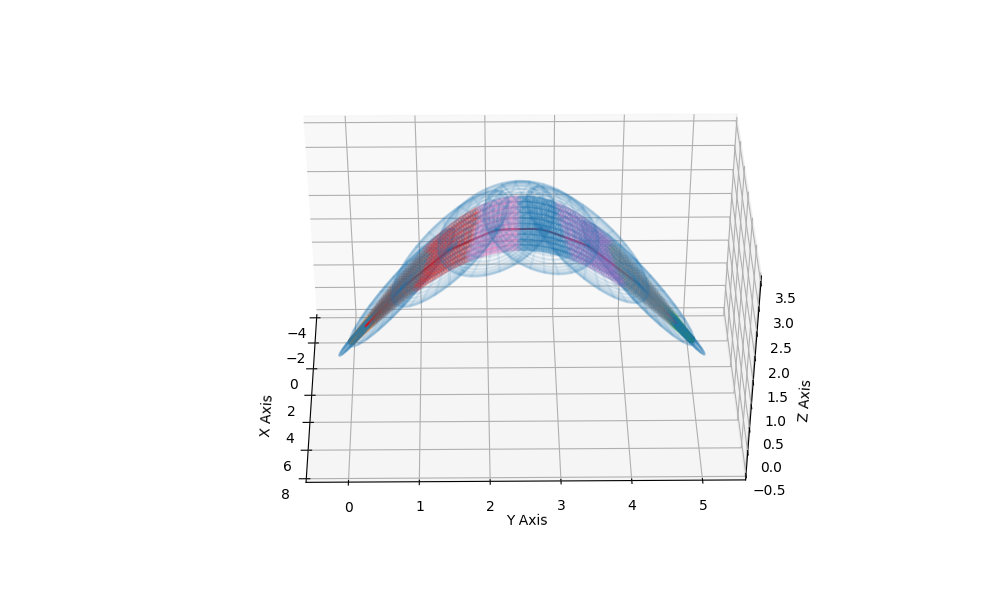

In [11]:
## Visualizing the sampled trajectory
fig = plt.figure(figsize=(10,6))
ax3 = fig.add_subplot(111, projection='3d')
ax3.set_xlabel('X Axis')
ax3.set_ylabel('Y Axis')
ax3.set_zlabel('Z Axis')
ax3.set_xlim([-4, 8])

plot_GMM(data, labels, gmm.means_[:,:3], gmm.covariances_[:,:3,:3], ax3)
new_traj = expData.copy()

ax3.plot(new_traj[0,:], new_traj[1,:], new_traj[2,:], alpha=2, zorder=5, color="red")

plt.show()

## If post-processing for smoothing is needed(optional)

In [12]:
# # Define the 3D points
# points = new_traj.T[:, :3]

# # Fit a smooth curve through the points using smoothing and interpolating using B-spline representation
# tck, u = splprep(points.T, s=1)

# # Evaluate the smooth curve at 100 points
# u_new = np.linspace(u.min(), u.max(), 100)
# x_new, y_new, z_new = splev(u_new, tck)

In [13]:
# ## Visualizing the sampled trajectory
# fig = plt.figure(figsize=(10,6))
# ax4 = fig.add_subplot(111, projection='3d')
# plot_GMM(data, labels, gmm.means_[:,:3], gmm.covariances_[:,:3,:3], ax4)
# ax4.plot(x_new, y_new, z_new, alpha=1, zorder=5, color="red")
# ax4.set_xlim([-4, 8])
# plt.show()

# Code for transforming the GMM to fit different start and end positions

In [14]:
# given 2 vectors, the function compute the rotation matrix between them
def rotation_matrix(point1, point2):
    
    point1 = np.around(point1, decimals=4)
    point2 = np.around(point2, decimals=4)
    # Normalize the points
    point1_normalized = point1 / np.linalg.norm(point1)
    point2_normalized = point2 / np.linalg.norm(point2)

    # Find the rotation matrix
    rotation = Rotation.align_vectors([point1_normalized], [point2_normalized])
    rotation_matrix = rotation[0].as_matrix()

    return rotation_matrix

In [15]:
# Main function to transform the mean and cov matrixes of the GMM
# start - old trained data start
# old_goal - old trained data goal
# new_start - new starting point
# new_goal - new goal point
# mean, cov of the trained GMM
# order - order of gaussians in visual appearance
def transform_gmm(start, old_goal, new_start, new_goal, mean, cov, order):
    
    # old vector of training data
    v_old = old_goal - start

    # new vector
    v_new = new_goal - new_start

    # rotation matrix to the new vector
    rot_mat_new = rotation_matrix(v_new, v_old)

    # start_shift
    start_shift = new_start - start
    
    # to get the new gaussian paramteres for new transition
    new_gmm_mean = mean[:,:3].copy()
    new_gmm_covariances = cov[:,:3,:3].copy()
    
    # length difference between old vector and new vector
    displacement_new = v_new - (rot_mat_new @ v_old)
    
    # distance between last Gaussian mean and the old start point
    # used to calculate the proportion based on which stretching and compression is done
    denominator = np.linalg.norm(mean[[order[-1]], :3] - start)
    
    for idx in range(k):
        # find the index of visually first gaussian
        index = order[idx]
        
        # distance between this gaussian mean and the old start point
        numerator = np.linalg.norm(mean[[order[idx]], :3] - start)
        # proportion of at how much length of the new trajectory should this gaussian mean appear.
        percentage = numerator/denominator
        
        # updating the mean of GMM
        # rotation matrix @ vector + translation
        new_gmm_mean[index] = (rot_mat_new @ (new_gmm_mean[index]-start)) + start + (displacement_new * percentage) + start_shift

        
        # updating the covariance of GMM
        # rotation matrix @ covariance matrix @ rotation matrix.Transpose
        new_gmm_covariances[index] = rot_mat_new @ new_gmm_covariances[index] @ rot_mat_new.T
        
    return new_gmm_mean, new_gmm_covariances

In [16]:
# trained start and end position can be retrieved from the training data
start = np.around(data[0, :-1], decimals=4)
old_goal = np.around(data[-1, :-1], decimals=4)

# sample testing
new_start = np.array([0., 0., 0.6])
new_goal = np.array([10., 3., 0.5])


# print("starting point is ", start)
# print("Trained LfD goal position is ", old_goal)
# print("new_start is ", new_start)
# print("new_goal is ", new_goal)


# sorting the index of gaussians based on visual representation
unique_elements, unique_indices = np.unique(labels[0:num_points], return_index=True)
gaussian_idx = unique_elements[np.argsort(unique_indices)]

# applying the transformation
new_gmm_mean, new_gmm_covariances = transform_gmm(start, old_goal, new_start, new_goal, gmm.means_,
                                                  gmm.covariances_, gaussian_idx)


# adding 4th time dimension to means
new_gmm_mean_4 = np.hstack((new_gmm_mean,gmm.means_[:,-1].reshape((8,1))))

# adding 4th time dimension to covariance
temp_cov = gmm.covariances_.copy()
temp_cov[:,:3,:3] = new_gmm_covariances[:]
new_gmm_covariances_4 = temp_cov.copy()

/opt/conda/lib/python3.8/site-packages/scipy/spatial/transform/rotation.py:1953: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  warnings.warn("Optimal rotation is not uniquely or poorly defined "


## Applying GMR on the transformed GMM

In [17]:
expData[0:nbVar-1, :], expSigma = GMR(gmm.weights_, new_gmm_mean_4.T, new_gmm_covariances_4.T, expData[-1, :], data.shape[1]-1,
                                              np.arange(0, nbVar-1))
new_traj_new_goal = expData.copy()

## Visualizing the transformed operation

<IPython.core.display.Javascript object>


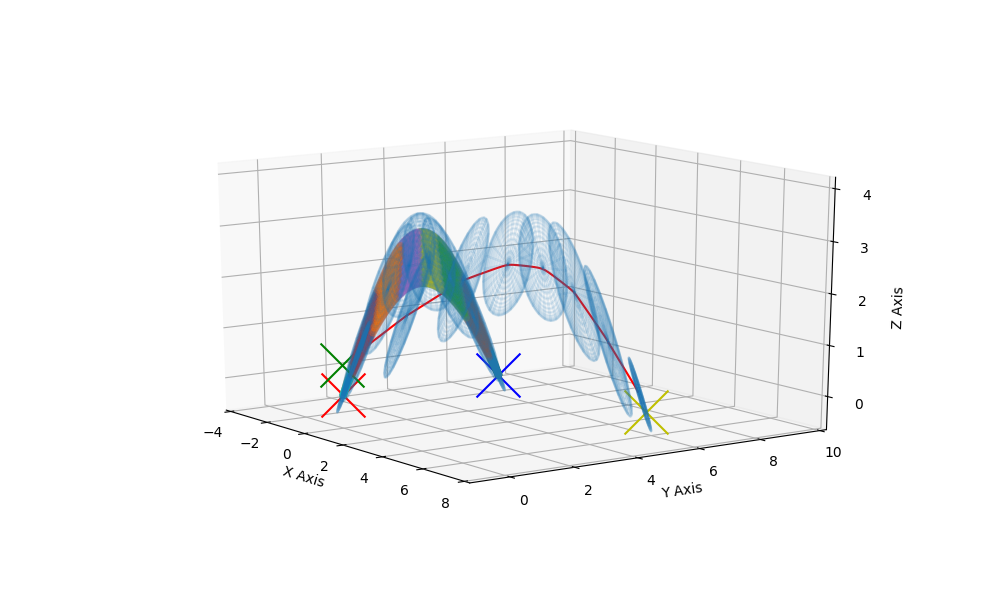

In [18]:
# Plot the ellipsoid
fig = plt.figure(figsize=(10,6))
ax4 = fig.add_subplot(111, projection='3d')
ax4.set_xlabel('X Axis')
ax4.set_ylabel('Y Axis')
ax4.set_zlabel('Z Axis')
ax4.set_xlim([-4, 8])
ax4.set_ylim([-1, 10]) 

# 4 markers
ax4.scatter(start[0], start[1], start[2], c='r', marker='x', s=1000)
ax4.scatter(old_goal[0], old_goal[1], old_goal[2], c='b', marker='x', s=1000)
ax4.scatter(new_start[0], new_start[1], new_start[2], c='g', marker='x', s=1000)
ax4.scatter(new_goal[0], new_goal[1], new_goal[2], c='y', marker='x', s=1000)


ax4.plot(new_traj[0,:], new_traj[1,:], new_traj[2,:], alpha=2, zorder=5, color="red")
ax4.plot(new_traj_new_goal[0,:], new_traj_new_goal[1,:], new_traj_new_goal[2,:], alpha=2, zorder=5, color="red")


plot_GMM(data, labels, gmm.means_[:,:3], gmm.covariances_[:,:3,:3], ax4)
plot_GMM(data, labels, new_gmm_mean, new_gmm_covariances, ax4)


plt.show()

# Setup the environment

# Robot related data

In [19]:
class Robot:

    def __init__(self, gmm_model, solution):
        # store the status of gripper
        self.robot_hand = False # initially false as it is not holding anything
        self.pose = np.array([0,0,0]) # robot gripper is at origin
        self.actions = ['pick', 'place'] # 2 actions needed for stacking
        self.goal = False # to check for goal state
        # store the GMM params for action learned through LFD
        self.lfd = gmm_model
        # store the task to be performed
        self.solution = solution
        self.counter = 0 # to count the step of action
        
    def choose_action(self, env):
        # select an action satisfying precondition
        for action in self.actions:
            if self.action_precondition(action, env):
                self.action = action
                return None
        # if none of the action is executable
        return False
    
    def action_precondition(self, action, env):
        # pick only if hand is free
        if action == 'pick' and self.robot_hand == False:
            if not np.array_equal(env.cubes[self.solution[self.counter]][:2], env.target):
                self.object = self.solution[self.counter]
                self.start = self.pose
                self.end = env.cubes[self.solution[self.counter]]
            else:
                self.counter+=1
            return True
        # place only if hand is full
        if action == 'place' and self.robot_hand == True:
            self.end = np.array([env.target[0], env.target[1], 0.5 + 0.1])
            self.start = self.pose
            self.end[2] += (self.counter*1)
            self.counter+=1
            return True
        
        return False
    
    def execute_action(self, env):
        # change the position of the cube
        if self.action == 'pick':
            # generate trajectory from robot curr pos to the cube
            traj = self.traj_generation(env, self.start, self.end)
            # generate plot
            env.plot_traj(traj)
            self.pose = env.cubes[self.object]
            self.robot_hand = True
        if self.action == 'place':
            # generate trajectory from robot curr pos to the goal
            traj = self.traj_generation(env, self.start, self.end)
            # generate plot
            env.plot_traj(traj)
            self.pose = self.end
            env.cubes[self.object] = self.end
            self.robot_hand = False
        print("executing action: " + self.action + " of object " + self.object)
        #print(env.cubes)
        self.action_postcondition(env)
        # if goal reached
        if self.check_goal_reached(env):
            self.goal = True
            print("executing completed. Goal reached")
    
    def action_postcondition(self, env):
        pass
    
    def check_goal_reached(self, env):
        flag = True
        # check if any of the cubes are not on x, y
        for key, value in env.cubes.items():
            if not np.array_equal(value[:2], env.target):
                flag = False
                break
        return flag
    
    def traj_generation(self, env, start, end):
        new_gmm_mean, new_gmm_covariances = transform_gmm(np.array([0,0,0]), np.array([0,5,0]), start, end,
                                                          self.lfd['means'], self.lfd['covs'], self.lfd['order'])
            
        # adding 4th time dimension to means
        new_gmm_mean_4 = np.hstack((new_gmm_mean,gmm.means_[:,-1].reshape((8,1))))

        # adding 4th time dimension to covariance
        temp_cov = gmm.covariances_.copy()
        temp_cov[:,:3,:3] = new_gmm_covariances[:]
        new_gmm_covariances_4 = temp_cov.copy()
        
        expData[0:nbVar-1, :], expSigma = GMR(gmm.weights_, new_gmm_mean_4.T, new_gmm_covariances_4.T, expData[-1, :], data.shape[1]-1,
                                              np.arange(0, nbVar-1))
        return expData.copy()

# Environment related data

In [20]:
class Environment:
    
    def __init__(self):
        # centroids of 3 cubes of side=1 at random positions 
        self.cubes = {'R':np.array([7, 6, 0.5]),
                      'B':np.array([5, 9, 0.5]),
                      'G':np.array([10, 5, 0.5]),
                      'Y':np.array([4, 6, 0.5])}
        self.cube_colors = {'R':'red',
                            'B':'blue',
                            'G':'green',
                            'Y':'yellow'}
        self.target = np.array([3,3]) # target where the cube is to be stacked
        self.traj = None

    
    # to plot the environment at the time instant
    def plot_env(self, fig_axis):
        fig_axis.cla()
        # plot the cube postions
        for key, value in self.cubes.items():
            vertices = [
                    [value[0] + 0.5, value[1] + 0.5, value[2] + 0.5],
                    [value[0] + 0.5, value[1] + 0.5, value[2] - 0.5],
                    [value[0] + 0.5, value[1] - 0.5, value[2] - 0.5],
                    [value[0] + 0.5, value[1] - 0.5, value[2] + 0.5],
                    [value[0] - 0.5, value[1] + 0.5, value[2] + 0.5],
                    [value[0] - 0.5, value[1] + 0.5, value[2] - 0.5],
                    [value[0] - 0.5, value[1] - 0.5, value[2] - 0.5],
                    [value[0] - 0.5, value[1] - 0.5, value[2] + 0.5]
                ]
            # Define the faces of the cube
            faces = [
                [vertices[0], vertices[1], vertices[2], vertices[3]],
                [vertices[0], vertices[4], vertices[5], vertices[1]],
                [vertices[1], vertices[5], vertices[6], vertices[2]],
                [vertices[2], vertices[6], vertices[7], vertices[3]],
                [vertices[0], vertices[3], vertices[7], vertices[4]],
                [vertices[4], vertices[7], vertices[6], vertices[5]]
            ]

            # Create a Poly3DCollection and add it to the plot
            cube = art3d.Poly3DCollection(faces, linewidths=1, edgecolors='k')
            cube.set_facecolor(self.cube_colors[key])
            fig_axis.add_collection3d(cube)

            # Set the axes limits and labels
            fig_axis.set_xlim([0, 12])
            fig_axis.set_ylim([0, 12])
            fig_axis.set_zlim([0, 5])
            fig_axis.set_xlabel('X')
            fig_axis.set_ylabel('Y')
            fig_axis.set_zlabel('Z')
            
            # mark the target
            fig_axis.plot([self.target[0]-1, self.target[0]+1], 
                          [self.target[1]-1, self.target[1]+1], [0, 0], color='red', linewidth=2)
            fig_axis.plot([self.target[0]+1, self.target[0]-1], 
                          [self.target[1]-1, self.target[1]+1], [0, 0], color='red', linewidth=2)
            
        
            if self.traj is not None:
                values = np.linspace(0, 1, self.traj.shape[1])
                #fig_axis.scatter(self.traj[0,:], self.traj[1,:], self.traj[2,:], alpha=1, zorder=5, color="purple")
                fig_axis.scatter(self.traj[0,:], self.traj[1,:], self.traj[2,:], alpha=1, zorder=5, c=values, cmap='viridis')
            
    def plot_traj(self, traj):
        self.traj = traj

# Task learning

In [21]:
%matplotlib inline

## Learning the pattern

Demonstraton 1
Type the cubes(R,G,B,Y) in the order of their stack needed (seperated by spaces) : Y R B G
Demonstraton 2
Type the cubes(R,G,B,Y) in the order of their stack needed (seperated by spaces) : Y B R G
Demonstraton 3
Type the cubes(R,G,B,Y) in the order of their stack needed (seperated by spaces) : 
Demonstration completed


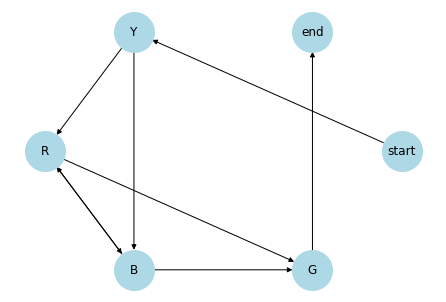

In [25]:
end_nodes = ['start', 'end']
graph = nx.DiGraph()
graph.add_nodes_from(end_nodes)


i = 0

while True:
    i+=1
    print("Demonstraton " + str(i))
    cubes = input("Type the cubes(R,G,B,Y) in the order of their stack needed (seperated by spaces) : ")
    
    # to stop the demonstration
    if len(cubes)==0:
        print("Demonstration completed")
        break
        
    # create nodes from cubes
    cubes = cubes.split()
    
    # need to check if the cube already exists, or else create a new node.
    for cube in cubes:
        if graph.has_node(cube):
            continue
        else:
            graph.add_node(cube)
            
    # need to add connections in the order in list.
    for idx in range(len(cubes)-1):
        graph.add_edge(cubes[idx], cubes[idx+1])
        
    # append start and end at the end
    graph.add_edge(end_nodes[0], cubes[0])
    graph.add_edge(cubes[-1], end_nodes[1])
    
    # visualize the demonstration in simulation

# visualize the graph
nx.draw_circular(graph, with_labels=True, node_size=1600, cmap=plt.cm.rainbow, node_color='lightblue')
plt.show()

## Generate a pattern

In [26]:
num_of_cubes = 4

solutions = [
    path
    for path in nx.all_simple_paths(graph, "start", "end")
    if len(path) == num_of_cubes + 2 
]

solution = random.choice(solutions)

print(solution)

['start', 'Y', 'R', 'B', 'G', 'end']


# Execution

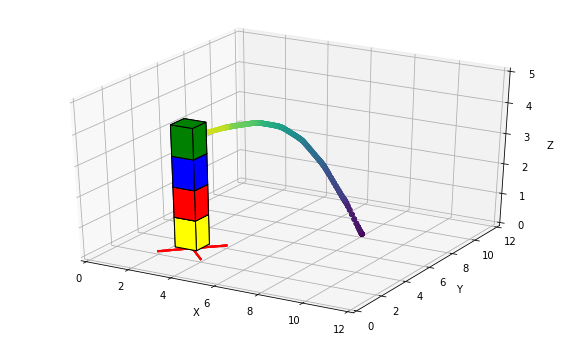

executing action: pick of object Y
executing action: place of object Y
executing action: pick of object R
executing action: place of object R
executing action: pick of object B
executing action: place of object B
executing action: pick of object G
executing action: place of object G
executing completed. Goal reached


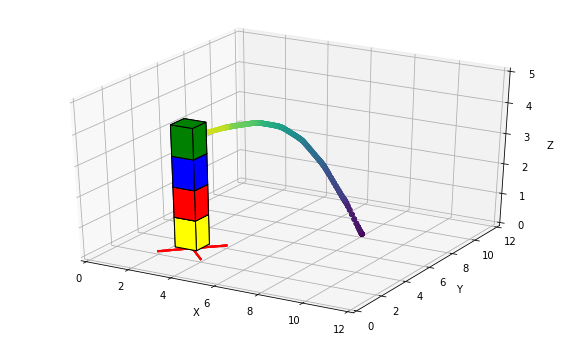

In [27]:
gmm_model = {}
gmm_model['means'] = gmm.means_.copy()
gmm_model['covs'] = gmm.covariances_.copy()
gmm_model['order'] = gaussian_idx.copy()


e = Environment()
r = Robot(gmm_model, solution[1:-1])

# Create a figure and a 3D axis
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
hfig = display(fig, display_id=True)
e.plot_env(ax)
fig.canvas.draw()
hfig.update(fig)
#plt.show()
time.sleep(5)


# until goal is reached
while r.goal == False:
    
    # choose action
    status = r.choose_action(e)
    
    if status == False:
        print("Error in the setup")
        break
    
    # execute action
    r.execute_action(e)
    
    # plot the environment
    #fig = plt.figure(figsize=(10,6))
    #ax = fig.gca(projection='3d')
    e.plot_env(ax)
    fig.canvas.draw()
    hfig.update(fig)
    time.sleep(5)
    e.plot_traj(None)